# Creación de base de datos para identificación de HVs

El presente archivo se creará la base de datos extrayendo información de HVs usando procesamiento de lenguaje natural. Esto con el objetivo de más adelante tener la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las características predominantes de una HV que hace que avance o no durante el proceso.



#### Importar librerias

In [1]:
import os
import fitz  # PyMuPDF for PDFs
import pytesseract
from PIL import Image
import pandas as pd
import re
import spacy
import io
import numpy as np

### Importar SpaCy para NLP
Spacy es una librería de python que permite por medio de modelos de lenguaje pre-importados realizar análisis de texto, identificando palabras, nombres, lugares, objetos, verbos, adjetivos y la relación entre los mismos.

En este caso, importamos el modelo pre-entrenado en inglés, lo que requiere que todas las CVs a procesar estén en este idioma.


In [2]:
nlp = spacy.load("en_core_web_sm")

#### Cargar las carpetas con las HVs

In [3]:
hv_dir_exitosas_java = "hojas_de_vida/java/Paso"
hv_dir_noexitosas_java = "hojas_de_vida/java/No Paso"
hv_dir_exitosas_front = "hojas_de_vida/frontend/Paso"
hv_dir_noexitosas_front = "hojas_de_vida/frontend/No Paso"

### Deifinir palabras clave
En este caso, se definirar palabras clave que podrán tener las HVs teniendo en cuenta que para este modelo en particular se está utlizando solo HVs para un requerimiento de **desarrolladores Java**.


In [4]:
palabras_clave_java = ["Java", "Spring", "spring boot", "AWS", "Azure", "GCP", "Google Cloud Platform", "microservices", "Maven", "Gradle", "Java Server Pages", "JSP", "JEE", "Java Enterprise Edition", "Java8", "Java11", "Java17", "Java21", "JVM", "Java virtual machine"]

palabras_clave_front_end = ["Javascript", "Typescript", "React", "Angular", "Vue", "react.js", "vue.js", "HTML", "CSS", "Redux", "Hooks", "Micro frontends"]

### Definir las secciones y los patrones en las que estas van a aparecer
Además de definir la cantidad de palabras clave, es importante contar con las secciones con las que cada documento puede contar y entender si cuenta o no con este.

In [5]:
secciones = {
    "education": r"education|academic background|studies|study|university studies|professional education",
    "work_experience": r"experience|work|work experience|employment history|professional experience|background|professional background",
    "skills": r"skills|technical skills|competencies",
    "certifications": r"certifications|licenses|accreditations",
    "achievements": r"achievements|achieved",
    "professional_profile": r"profile|summary|about me|professional summary|objective|summary",
    "languages": r"languages|linguistic skills|spoken languages",
    "projects": r"projects|case studies|portfolio",
    "publications": r"publications|research papers|articles|books",
    "training_courses": r"training|courses|workshops|online learning",
    "volunteer_work": r"volunteer|volunteering|social impact|community service",
}

### Detectar el tipo de HV para posterior procesamiento de palabras clave


In [6]:
def detect_cv_type(cv_path):
    if "java" in cv_path.lower():
        return "java"
    elif "frontend" in cv_path.lower():
        return "frontend"
    else:
        return "unknown"  # Default case if it's unclear

### Extraer el texto de los PDFs

A continuación se usará la librería FITZ, la cual ayuda a extraer el texto de un PDF, ver si tiene imágenes, contar sus páginas y detectar colores en los mismos.

La declaramos como función para llamarla más adelante en el procesamiento de todas las características que buscamos extraer.

In [7]:
def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF, handling both text-based and image-based (scanned) content."""
    text = []
    try:
        doc = fitz.open(pdf_path)

        for page in doc:
            # Extract text from the page (use "blocks" for better structure)
            page_text = "\n".join(block[4] for block in page.get_text("blocks"))
            text.append(page_text)

            # Handle OCR for image-based text (scanned PDFs)
            for img_index, img in enumerate(page.get_images(full=True)):
                base_image = doc.extract_image(img[0])
                img_bytes = base_image["image"]

                # Convert image bytes to a PIL image
                img_pil = Image.open(io.BytesIO(img_bytes))

                # ✅ Fix: Convert RGBA or P-mode images (with transparency) to RGB
                if img_pil.mode in ("RGBA", "P"):
                    img_pil = img_pil.convert("RGB")

                # Convert image to text using OCR
                ocr_text = pytesseract.image_to_string(img_pil)
                text.append(ocr_text)

    except Exception as e:
        print(f"❌ Error extracting text from {pdf_path}: {e}")

    return "\n".join(text).strip()

### Contar palabras en general

In [8]:
def contar_palabras(text):
    return len(text.split()) if text else 0

#### Contar palabras clave

In [9]:
def contar_palabras_clave(text, cv_type):
    """
    Counts occurrences of keywords in the CV text using regex for better accuracy.
    - Handles variations like hyphens, spaces, and case differences.
    - Uses word boundaries `\b` but allows for slight variations in spacing.
    """
    text_lower = text.lower()

    # Choose the correct keyword list based on CV type
    keyword_list = palabras_clave_java if cv_type == "java" else palabras_clave_front_end

    count = 0
    for keyword in keyword_list:
        keyword_pattern = re.escape(keyword).replace(" ", r"\s*[-_]?\s*")  # ✅ Fix: Create regex separately
        keyword_regex = rf"\b{keyword_pattern}\b"  # ✅ Now safely formatted

        matches = re.findall(keyword_regex, text_lower, re.IGNORECASE)
        count += len(matches)  # Sum occurrences

    return count

#### Extraer las secciones

Para extraer las secciones, usamos expresiones regulares. Con la biblioteca Re, busca el patron definido en la variable secciones más arriba, que ayuda a identificar si el texto obtenido del PDF tiene o no esta sección.

In [10]:
def extraer_secciones(text):
    """
    Extracts sections from the CV text using regex patterns.
    - Matches variations of section headers (Education, Work Experience, etc.).
    - Uses `re.split()` instead of `re.finditer()` to extract actual content.
    - Handles missing sections properly by defaulting to end of text.
    """
    sections = {key: {"exists": False, "word_count": 0} for key in secciones.keys()}

    # ✅ Build a single regex pattern to split text by sections
    section_regex = rf"({'|'.join(secciones.values())})\s*[:\-]?\s*\n?"

    # ✅ Split text into sections
    split_text = re.split(section_regex, text, flags=re.IGNORECASE)

    if len(split_text) < 2:
        return sections  # No sections detected

    # ✅ Iterate through the detected sections
    for i in range(1, len(split_text) - 1, 2):  # Skip odd indexes (section names)
        section_name = split_text[i].strip().lower()  # Normalize section name
        section_content = split_text[i + 1].strip()  # Get the content under this section

        # ✅ Find the best-matching section key
        for key, pattern in secciones.items():
            if re.search(pattern, section_name, re.IGNORECASE):
                sections[key]["exists"] = True
                sections[key]["word_count"] = contar_palabras(section_content)
                break  # Stop checking once we find a match

    return sections


### Verificar factores como foto y colores
De vuelta se usa la librería fitz para poder leer el PDF

#### Verificar si tiene o no foto

In [11]:
def tiene_foto_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        for page in doc:
            if len(page.get_images(full=True)) > 0:
                return True
    except Exception as e:
        print(f"Error revisando foto en PDF {pdf_path}: {e}")
    return False

#### Verificar si tiene colores adicionales el PDF

In [12]:
def tiene_color_pdf(pdf_path):
    """Detects if a PDF contains non-black/gray colors in drawings or images."""
    try:
        doc = fitz.open(pdf_path)

        for page in doc:
            # Check vector elements (lines, shapes)
            for draw in page.get_drawings():
                if "color" in draw and draw["color"] is not None:  # ✅ Check if "color" exists
                    r, g, b = draw["color"]
                    if (r, g, b) != (0, 0, 0) and r != g != b:  # Exclude black & grayscale
                        return True

            # Check images in the PDF
            for img_index, img in enumerate(page.get_images(full=True)):
                base_image = doc.extract_image(img[0])
                img_bytes = base_image["image"]

                # Convert image bytes to a PIL image
                img_pil = Image.open(io.BytesIO(img_bytes))

                # ✅ Fix: Convert RGBA images (with transparency) to RGB
                if img_pil.mode == "RGBA":
                    img_pil = img_pil.convert("RGB")

                # Convert image to a NumPy array
                img_np = np.array(img_pil)

                # Check if the image contains any non-grayscale pixels
                if len(img_np.shape) == 3:  # Ensure it's a color image
                    r, g, b = img_np[:, :, 0], img_np[:, :, 1], img_np[:, :, 2]
                    if np.any((r != g) | (g != b)):  # If any pixel has unequal R, G, B, it's colored
                        return True

    except Exception as e:
        print(f"❌ Error detecting color in PDF {pdf_path}: {e}")

    return False  # If no color found, return False

#### Contar páginas

In [13]:
def contar_paginas(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        return len(doc)
    except Exception as e:
        print(f"Error counting pages in PDF {pdf_path}: {e}")
        return 1

### Procesamiento del CV
A continuación la función de procesamiento, nos ayudará a procesar un solo CV de acuerdo a los parámetros establecidos anteriormente, ejecutando cada una de las funciones ya establecidas

In [14]:
def process_cv(cv_path):
    tipo_cv = detect_cv_type(cv_path)

    text = extract_text_from_pdf(cv_path)
    if not text:
        print(f"⚠️ No text extracted from {cv_path}")

    has_photo = tiene_foto_pdf(cv_path)
    has_colors = tiene_color_pdf(cv_path)
    num_pages = contar_paginas(cv_path)

    total_word_count = contar_palabras(text)
    keyword_count = contar_palabras_clave(text, tipo_cv)
    sections = extraer_secciones(text)

    return {
        "CV_Name": os.path.basename(cv_path),
        "Total_Word_Count": total_word_count,
        "Has_Photo": int(has_photo),
        "Has_Colors": int(has_colors),
        "Pages": num_pages,
        "Keyword_Count": keyword_count,
        "Education_Exists": int(sections["education"]["exists"]),
        "Education_Word_Count": sections["education"]["word_count"],
        "Work_Experience_Exists": int(sections["work_experience"]["exists"]),
        "Work_Experience_Word_Count": sections["work_experience"]["word_count"],
        "Skills_Exists": int(sections["skills"]["exists"]),
        "Skills_Word_Count": sections["skills"]["word_count"],
        "Certifications_Exists": int(sections["certifications"]["exists"]),
        "Certifications_Word_Count": sections["certifications"]["word_count"],
        "Achievements_Exists": int(sections["achievements"]["exists"]),
        "Achievements_Word_Count": sections["achievements"]["word_count"],
        "Professional_Profile_Exists": int(sections["professional_profile"]["exists"]),
        "Professional_Profile_Word_Count": sections["professional_profile"]["word_count"],
        "Projects_Exists": int(sections["projects"]["exists"]),
        "projects_Word_Count": sections["projects"]["word_count"],
        "volunteer_work_Exists": int(sections["volunteer_work"]["exists"]),
        "volunteer_work_Word_Count": sections["volunteer_work"]["word_count"]
    }

### Procesamiento de CVs en la carpeta
La siguiente función nos ayuda a de acuerdo con lo establecido anteriormente, procesar todas las CVs en las carpetas seleccionadas y devolverlas en una lista

In [15]:
def process_folder(folder_path, label):
    cv_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            cv_path = os.path.join(folder_path, filename)
            print(f"Processing: {cv_path}")
            cv_info = process_cv(cv_path)
            cv_info["Passed"] = label
            cv_data.append(cv_info)
    return cv_data

## Creación de la base de datos

Se crean las variables donde se almacenan las CVs exitosas procesadas, agregando la información de 1 si es exitosa y 0 si no es exitosa.

In [16]:
# 📌 Process All CVs & Create Dataset
data_total = (process_folder(hv_dir_exitosas_java, 1) +
              process_folder(hv_dir_noexitosas_java, 0) +
              process_folder(hv_dir_exitosas_front, 1) +
              process_folder(hv_dir_noexitosas_front, 0))

Processing: hojas_de_vida/java/Paso\11686212-CV-Jorge Vidal.pdf
Processing: hojas_de_vida/java/Paso\14483303-Andres_Gomez_resume.docx (2) (1).pdf
Processing: hojas_de_vida/java/Paso\14503315-CV - Henry Luis Gomez Ortiz [En] (1) (1).pdf
Processing: hojas_de_vida/java/Paso\14955159-Curriculum vitae english (1).pdf
Processing: hojas_de_vida/java/Paso\8A9EBB5F-08ED-4D90-92C2-72A9024C2A58.pdf
Processing: hojas_de_vida/java/Paso\985269fa-a528-46aa-bc9c-403ee23fbcd3_CV Felipe Feres .pdf
Processing: hojas_de_vida/java/Paso\ABD57CA0-6506-4FF2-84B3-42F845509854.pdf
Processing: hojas_de_vida/java/Paso\Agustin Castro CV.pdf
Processing: hojas_de_vida/java/Paso\Alex Diaz CV - 2022.pdf
Processing: hojas_de_vida/java/Paso\alexis_pequeno_cv_en.pdf
Processing: hojas_de_vida/java/Paso\BBD1018F-127C-4C11-98CA-12E050D26B3B.pdf
Processing: hojas_de_vida/java/Paso\Byron Andrago CV.pdf
Processing: hojas_de_vida/java/Paso\Carlos Pinto Jimenez_CV.docx.pdf
Processing: hojas_de_vida/java/Paso\Christian_Blanco_CV_

Se guarda esta información en un dataframe

In [17]:
baseCVs = pd.DataFrame(data_total)

#borramos el CV name ya que no es necesaria y buscamos información anónima
baseCVs = baseCVs.drop('CV_Name', axis=1)

#Aleatorizamos el orden para que no queden juntos los 1 y los 0 todos juntos y las muestras sean más representativas
baseCVs = baseCVs.sample(frac=1, random_state=42).reset_index(drop=True)


In [18]:
baseCVs

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
0,349,0,1,3,41,1,14,1,7,1,...,0,0,0,1,7,1,5,0,0,0
1,966,1,1,9,33,1,15,1,400,1,...,29,1,17,0,0,0,0,0,0,0
2,789,0,1,4,9,1,17,1,10,1,...,0,0,0,1,0,0,0,0,0,0
3,1206,0,0,4,23,0,0,1,34,1,...,0,0,0,0,0,1,135,1,53,1
4,715,1,1,3,24,1,28,1,170,1,...,33,0,0,1,179,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1129,0,0,4,59,1,12,1,18,1,...,0,0,0,1,37,0,0,0,0,1
644,2185,1,1,7,68,1,14,1,2,1,...,0,0,0,1,4,1,171,0,0,1
645,573,0,0,2,28,1,28,1,172,0,...,0,0,0,1,21,0,0,0,0,0
646,1202,1,1,6,30,1,198,1,29,1,...,0,0,0,0,0,1,95,0,0,1


### Exportar base en un archivo CSV para posterior lectura

In [19]:
#baseCVs.to_csv("baseCVs.csv", index=False)

## Limpieza de la base
Buscaremos imputar outliers y tener la base más óptima posible para el modelo predictivo

Primero, un descriptivo de la base

In [20]:
baseCVs.describe()

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
count,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,...,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000
mean,716.841049,0.510802,0.603395,2.816358,21.442901,0.794753,24.021605,0.972222,81.587963,0.763889,...,5.302469,0.118827,6.399691,0.541667,14.944444,0.604938,34.922840,0.021605,0.418210,0.418210
std,451.630271,0.500269,0.489571,2.363147,16.155824,0.404194,34.365786,0.164462,113.630295,0.425019,...,20.839443,0.323835,36.310985,0.498646,47.112775,0.489242,66.320217,0.145502,4.391517,0.493646
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.500000,0.000000,0.000000,1.000000,11.000000,1.000000,1.000000,1.000000,14.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,610.500000,1.000000,1.000000,2.000000,17.000000,1.000000,15.000000,1.000000,41.500000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
75%,881.000000,1.000000,1.000000,3.000000,28.000000,1.000000,30.000000,1.000000,107.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000,42.250000,0.000000,0.000000,1.000000
max,3729.000000,1.000000,1.000000,38.000000,121.000000,1.000000,328.000000,1.000000,951.000000,1.000000,...,291.000000,1.000000,723.000000,1.000000,663.000000,1.000000,672.000000,1.000000,80.000000,1.000000


### Revisamos correlaciones con la variable 'Passed'

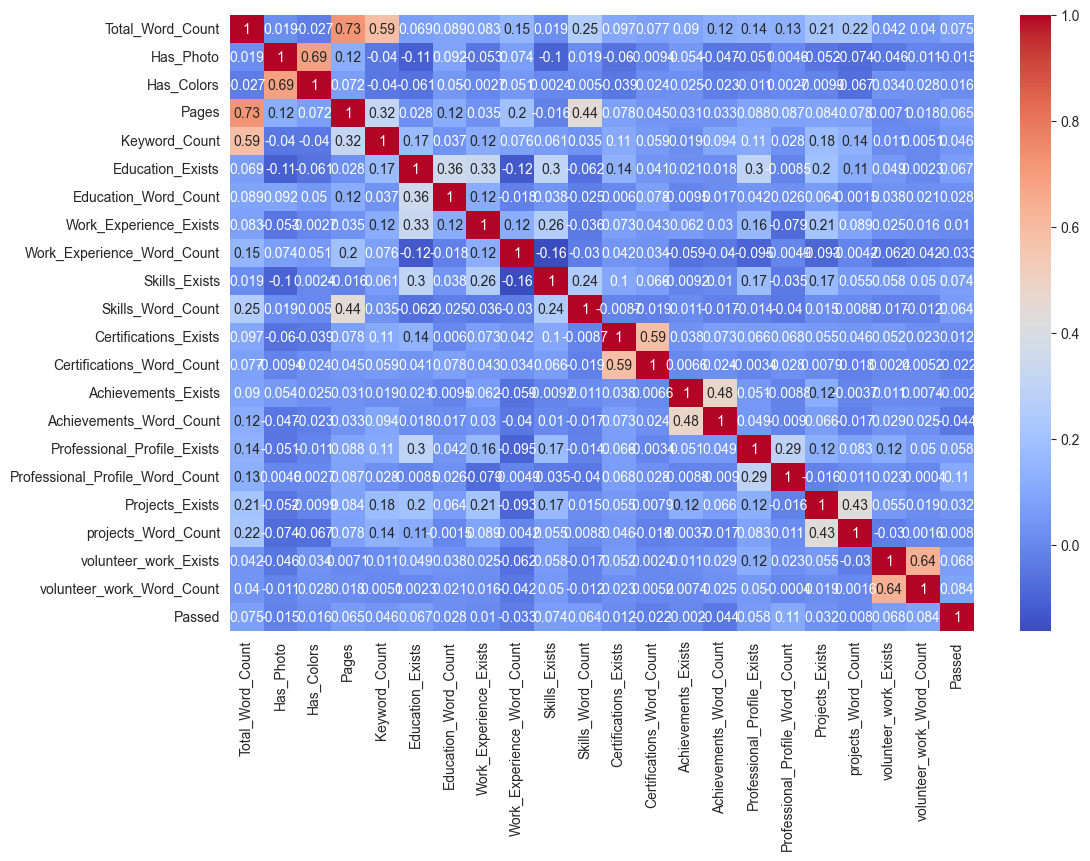

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(baseCVs.corr(), annot=True, cmap="coolwarm")
plt.show()

In [23]:
# Get correlation with "Passed" column
correlation_with_target = baseCVs.corr()["Passed"].drop("Passed")  # Remove self-correlation

# Sort features by absolute correlation value (strongest correlations first)
important_features = correlation_with_target.abs().sort_values(ascending=False)

# Display top 10 most important features
print("🔹 Top 15 Most Correlated Features with 'Passed':")
print(important_features.head(15))


🔹 Top 15 Most Correlated Features with 'Passed':
Professional_Profile_Word_Count    0.109724
volunteer_work_Word_Count          0.083891
Total_Word_Count                   0.074984
Skills_Exists                      0.073564
volunteer_work_Exists              0.067677
Education_Exists                   0.066787
Pages                              0.064612
Skills_Word_Count                  0.064374
Professional_Profile_Exists        0.057819
Keyword_Count                      0.046119
Achievements_Word_Count            0.043572
Work_Experience_Word_Count         0.032606
Projects_Exists                    0.032393
Education_Word_Count               0.028257
Certifications_Word_Count          0.022382
Name: Passed, dtype: float64


### Revisamos con random forest las que más contribuyen

In [24]:
from sklearn.ensemble import RandomForestClassifier

X = baseCVs.drop("Passed", axis=1)
y = baseCVs["Passed"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))


Total_Word_Count                   0.143397
Work_Experience_Word_Count         0.127405
Keyword_Count                      0.124093
Education_Word_Count               0.103125
Skills_Word_Count                  0.099253
projects_Word_Count                0.086260
Professional_Profile_Word_Count    0.075396
Pages                              0.059034
Certifications_Word_Count          0.025950
Achievements_Word_Count            0.023546
Has_Colors                         0.021368
Has_Photo                          0.020962
Professional_Profile_Exists        0.016540
Projects_Exists                    0.014847
Skills_Exists                      0.013156
Education_Exists                   0.011347
Certifications_Exists              0.011236
Achievements_Exists                0.010963
volunteer_work_Word_Count          0.004603
volunteer_work_Exists              0.004183
Work_Experience_Exists             0.003335
dtype: float64


In [26]:
top_features = feature_importances.nlargest(10).index
print((top_features))

Index(['Total_Word_Count', 'Work_Experience_Word_Count', 'Keyword_Count',
       'Education_Word_Count', 'Skills_Word_Count', 'projects_Word_Count',
       'Professional_Profile_Word_Count', 'Pages', 'Certifications_Word_Count',
       'Achievements_Word_Count'],
      dtype='object')


### Revisamos el balanceo de la base

In [27]:
print(baseCVs["Passed"].value_counts(normalize=True))  # Show % of each class

Passed
0    0.58179
1    0.41821
Name: proportion, dtype: float64


### Identificamos outliers

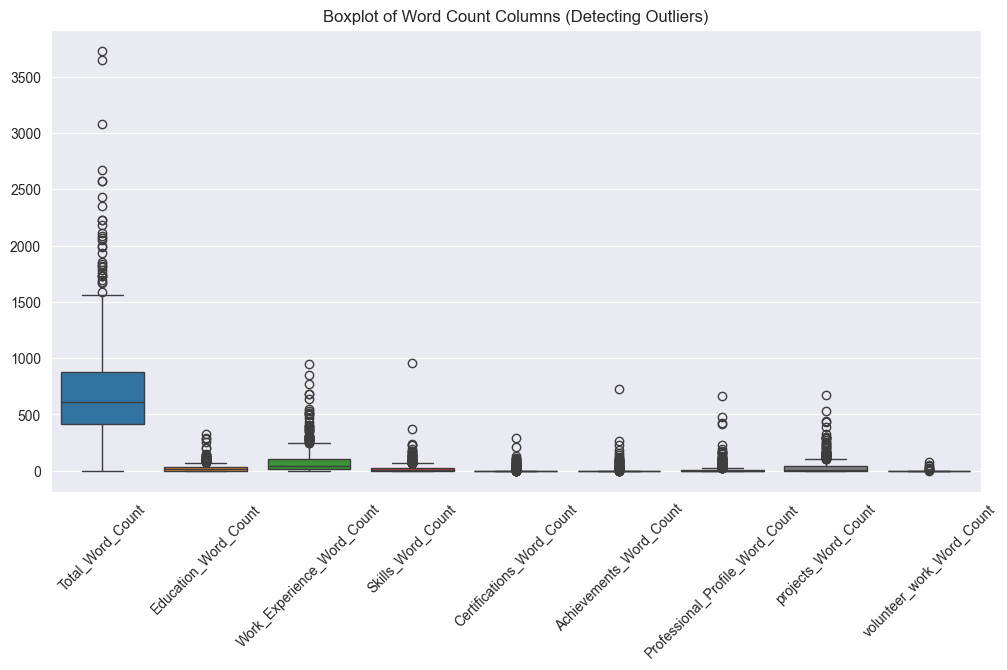

In [28]:
#Creamos una variable que nos permite separar las variables word_count, las que pueden presentar mayor cantidad de outliers
word_count_cols = [col for col in baseCVs.columns if "Word_Count" in col]  # Get all word count columns

plt.figure(figsize=(12, 6))
sns.boxplot(data=baseCVs[word_count_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Word Count Columns (Detecting Outliers)")
plt.show()

In [29]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Print outliers for each word count column
for col in word_count_cols:
    outliers = detect_outliers_iqr(baseCVs, col)
    print(f"📌 {col} has {len(outliers)} outliers.")

📌 Total_Word_Count has 31 outliers.
📌 Education_Word_Count has 36 outliers.
📌 Work_Experience_Word_Count has 42 outliers.
📌 Skills_Word_Count has 59 outliers.
📌 Certifications_Word_Count has 98 outliers.
📌 Achievements_Word_Count has 75 outliers.
📌 Professional_Profile_Word_Count has 78 outliers.
📌 projects_Word_Count has 60 outliers.
📌 volunteer_work_Word_Count has 10 outliers.


### Imputamos outliers con la técnica winsorization
Limitamos los outliers al 5%

In [34]:
from scipy.stats.mstats import winsorize

for col in word_count_cols:
    baseCVs[col] = winsorize(baseCVs[col], limits=[0, 0.10])

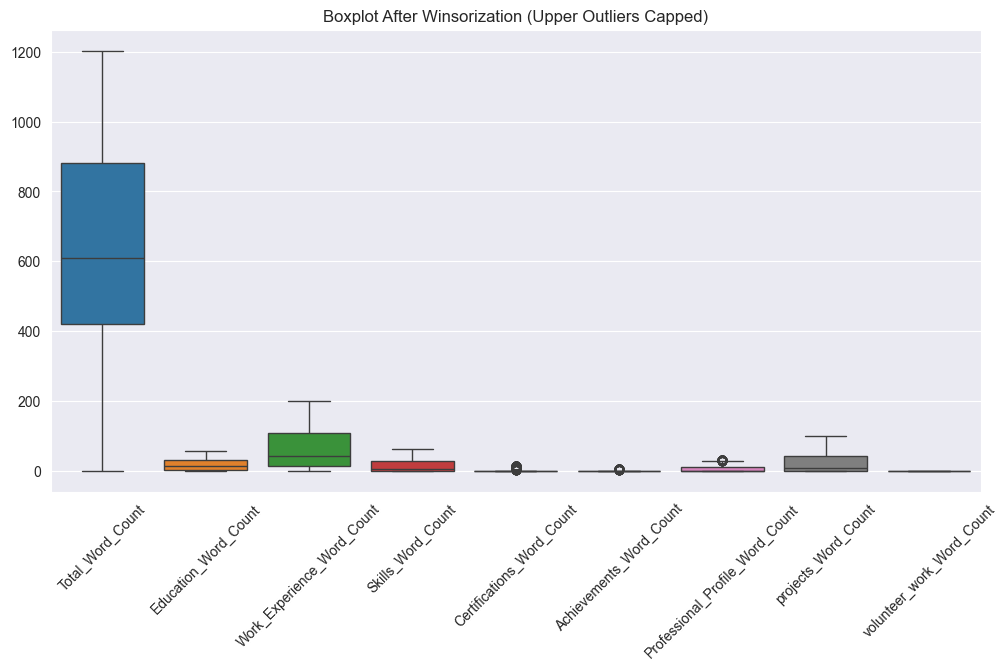

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=baseCVs[word_count_cols])
plt.xticks(rotation=45)
plt.title("Boxplot After Winsorization (Upper Outliers Capped)")
plt.show()

In [36]:
baseCVs

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
0,349,0,1,3,41,1,14,1,7,1,...,0,0,0,1,7,1,5,0,0,0
1,966,1,1,9,33,1,15,1,199,1,...,14,1,6,0,0,0,0,0,0,0
2,789,0,1,4,9,1,17,1,10,1,...,0,0,0,1,0,0,0,0,0,0
3,1203,0,0,4,23,0,0,1,34,1,...,0,0,0,0,0,1,100,1,0,1
4,715,1,1,3,24,1,28,1,170,1,...,14,0,0,1,32,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1129,0,0,4,59,1,12,1,18,1,...,0,0,0,1,32,0,0,0,0,1
644,1203,1,1,7,68,1,14,1,2,1,...,0,0,0,1,4,1,100,0,0,1
645,573,0,0,2,28,1,28,1,172,0,...,0,0,0,1,21,0,0,0,0,0
646,1202,1,1,6,30,1,57,1,29,1,...,0,0,0,0,0,1,95,0,0,1


In [37]:
baseCVs.to_csv("baseCVs.csv", index=False)